In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import h5py

sns.set()
tf.enable_eager_execution()
tf.set_random_seed(1867)

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

(60000, 28, 28)


In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(100, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def test(model, dataset):
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in dataset:
        outputs = model(x)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    return epoch_accuracy.result().numpy()

In [5]:
def train(model, dataset, epochs):
    training_accuracies = []
    for e in range(epochs):
        epoch_loss_avg = tf.contrib.eager.metrics.Mean()
        epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
        for x, y in dataset:
            with tf.GradientTape() as tape:
                outputs = model(x)
                loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(
                zip(grads, model.trainable_weights), global_step)
            epoch_loss_avg(loss)
            epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
        training_accuracies.append(epoch_accuracy.result())
    return model, training_accuracies
    

In [6]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

model, training_accuracies = train(model, dataset_train, 10)

model.save("./LeNet300_100_mnist_results/before_pruning.h5")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.


In [7]:
t = time.clock()
a = test(model,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.9735, Timing: 0.94s


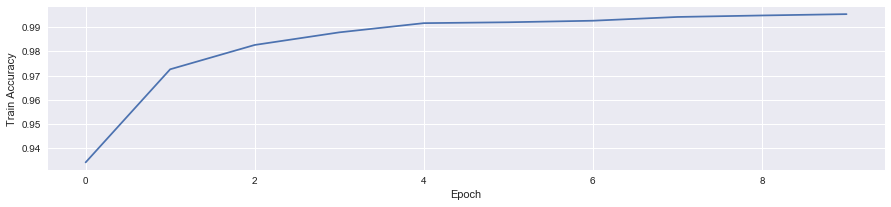

In [8]:
# Plot training curves
plt.figure(1, figsize=(15,3))
plt.plot(training_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy');

In [9]:
def prune_weights(dense_model, percentile):
    prev_kept_columns = None
    pruned_model = tf.keras.models.Sequential()
    pruned_model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    num_layers = len(dense_model.trainable_weights)

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()
        
        # Remove pruned columns
        if i_layer < num_layers-1: # Do not prune last layer
            column_norms = np.linalg.norm(weights_np, ord=2, axis=0)
            critical_value = np.percentile(column_norms, percentile)
            keep_mask = column_norms >= critical_value
            weights_np = weights_np[:, keep_mask]
            
        # Remove rows corresponding to previous layer's pruned columns
        if prev_kept_columns is not None:
            weights_np = weights_np[prev_kept_columns, :]
        
        # Record which columns were kept
        if i_layer < num_layers-1: # No pruned columns in last layer
            prev_kept_columns = np.argwhere(keep_mask).reshape(-1)
        
        # Add new layer to sparse model
        new_layer = tf.keras.layers.Dense(weights_np.shape[1], activation=tf.nn.relu, use_bias=False)
        pruned_model.add(new_layer)
        new_layer.set_weights([weights_np])
        
    return pruned_model

In [10]:
pruned_model_50 = prune_weights(model, 50)

pruned_model_50.save("./LeNet300_100_mnist_results/after_pruning_50.h5")


t = time.clock()
a = test(pruned_model_50,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.9366, Timing: 0.51s


In [11]:
pruned_model_50_retrain, prune_training_accuracies_50 = train(pruned_model_50, dataset_train, 10)
    
t = time.clock()
a = test(pruned_model_50_retrain,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

pruned_model_50_retrain.save("./LeNet300_100_mnist_results/pruned_retrained_50.h5")

Test Accuracy: 0.9809, Timing: 0.84s


In [12]:
pruned_model_60 = prune_weights(model, 60)

pruned_model_60.save("./LeNet300_100_mnist_results/after_pruning_60.h5")


t = time.clock()
a = test(pruned_model_60,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.8927, Timing: 0.85s


In [13]:
pruned_model_60_retrain, prune_training_accuracies_60 = train(pruned_model_60, dataset_train, 10)
    
t = time.clock()
a = test(pruned_model_60_retrain,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

pruned_model_60_retrain.save("./LeNet300_100_mnist_results/pruned_retrained_60.h5")

Test Accuracy: 0.9776, Timing: 0.81s


In [14]:
pruned_model_70 = prune_weights(model, 70)

pruned_model_70.save("./LeNet300_100_mnist_results/after_pruning_70.h5")


t = time.clock()
a = test(pruned_model_70,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.7496, Timing: 0.57s


In [15]:
pruned_model_70_retrain, prune_training_accuracies_70 = train(pruned_model_70, dataset_train, 10)
    
t = time.clock()
a = test(pruned_model_70_retrain,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

pruned_model_70_retrain.save("./LeNet300_100_mnist_results/pruned_retrained_70.h5")

Test Accuracy: 0.9774, Timing: 0.81s


In [16]:
pruned_model_80 = prune_weights(model, 80)

pruned_model_80.save("./LeNet300_100_mnist_results/after_pruning_80.h5")


t = time.clock()
a = test(pruned_model_80,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.5442, Timing: 0.74s


In [17]:
pruned_model_80_retrain, prune_training_accuracies_80 = train(pruned_model_80, dataset_train, 10)
    
t = time.clock()
a = test(pruned_model_80_retrain,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

pruned_model_80_retrain.save("./LeNet300_100_mnist_results/pruned_retrained_80.h5")

Test Accuracy: 0.9762, Timing: 0.81s


In [18]:
pruned_model_90 = prune_weights(model, 90)

pruned_model_90.save("./LeNet300_100_mnist_results/after_pruning_90.h5")


t = time.clock()
a = test(pruned_model_90,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

Test Accuracy: 0.3043, Timing: 0.85s


In [19]:
pruned_model_90_retrain, prune_training_accuracies_90 = train(pruned_model_90, dataset_train, 10)

t = time.clock()
a = test(pruned_model_90_retrain,dataset_test)
t = time.clock() - t
print(f"Test Accuracy: {a:.4f}, Timing: {t:.2f}s")

pruned_model_90_retrain.save("./LeNet300_100_mnist_results/pruned_retrained_90.h5")

Test Accuracy: 0.8756, Timing: 0.66s
